In [1]:
import os
import time
from pathlib import Path

import torch
import torchaudio
import librosa
import numpy as np

import pandas as pd
import shutil
from tqdm import tqdm

import seaborn as sns
import math

import matplotlib.pyplot as plt
from mutagen.mp3 import MP3

In [2]:
def calculate_total_duration(dataset_path):
    total_duration = 0
    audio_extensions = ['.mp3']
    file_count = 0
    error_count = 0
    
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                file_path = os.path.join(root, file)
                try:
                    audio = MP3(file_path)
                    total_duration += audio.info.length
                    file_count += 1
                except Exception as e:
                    error_count += 1


    hours = total_duration / 3600
    print(f"Duração total: {hours:.2f} horas ({int(hours)} horas e {int((hours % 1) * 60)} minutos)")
    print(f"Duração em segundos: {total_duration:.2f}s")
    print(f"Total de arquivos processados: {file_count}")
    print(f"Arquivos com erro: {error_count}")

# Filter non-validated audios

In [9]:
# parâmetros para o dataset Common Voice 4

metadata_file = Path("data/common-voice-dataset-version-4/data-file/validated.tsv") # votos do crowdsource
clips_dir = Path("data/common-voice-dataset-version-4/new-clip/")
output_dir = Path("data/1_validated-audio/")
min_votes = 2
dry_run = False # apenas mostra estatísticas sem copiar arquivos

output_dir.mkdir(exist_ok=True)

In [10]:
df = pd.read_csv(metadata_file, sep='\t', low_memory=False)

# Normalizar colunas numéricas que podem ter tipos mistos
for col in ['votes_up', 'votes_down', 'duration']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Total de clips: {len(df)}")
print(df.head(5))

Total de clips: 854444
                                           client_id  \
0  0013037a1d45cc33460806cc3f8ecee9d536c45639ba4c...   
1  001509f4624a7dee75247f6a8b642c4a0d09f8be3eeea6...   
2  003fb666a99eb3aa3ba05d9c8641c18e55cf7d34d1b981...   
3  004017ba82a23768d58dff3b91da8e8f951ea5fb6d3cd9...   
4  0047f1aea3f39c4c6a9298d84f046c1f84f439f594d840...   

                           path  \
0    common_voice_en_699711.mp3   
1  common_voice_en_18132047.mp3   
2  common_voice_en_17263741.mp3   
3  common_voice_en_17893917.mp3   
4  common_voice_en_17561821.mp3   

                                            sentence  up_votes  down_votes  \
0                               She'll be all right.         2           1   
1                         All's well that ends well.         2           0   
2                                    Do you mean it?         2           0   
3  The new patch is less invasive than the old on...         2           1   
4  How is Mozilla going to handle ambig

In [5]:
# Contar NaNs por coluna e mostrar porcentagem
missing_count = df.isna().sum()
missing_pct = (df.isna().mean() * 100).round(2)

missing_stats = pd.DataFrame({
    'missing_count': missing_count,
    'missing_pct': missing_pct
}).sort_values('missing_pct', ascending=False)

print("Percentual de NaNs por coluna de metadado:")
print(missing_stats)

# Percentual de linhas sem NaNs em todas as colunas
complete_mask = df.notna().all(axis=1)
complete_count = int(complete_mask.sum())
complete_pct = complete_count / len(df) * 100

print(f"\nÁudios com todos os campos presentes: {complete_count} de {len(df)} ({complete_pct:.2f}%)")

Percentual de NaNs por coluna de metadado:
            missing_count  missing_pct
accent             439255        51.41
age                335214        39.23
gender             332721        38.94
client_id               0         0.00
path                    0         0.00
sentence                6         0.00
up_votes                0         0.00
down_votes              0         0.00

Áudios com todos os campos presentes: 407655 de 854444 (47.71%)


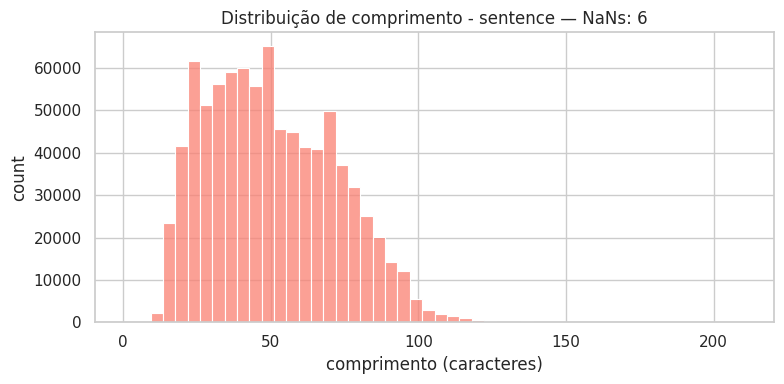

/tmp/ipykernel_98985/1971147714.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette="viridis")


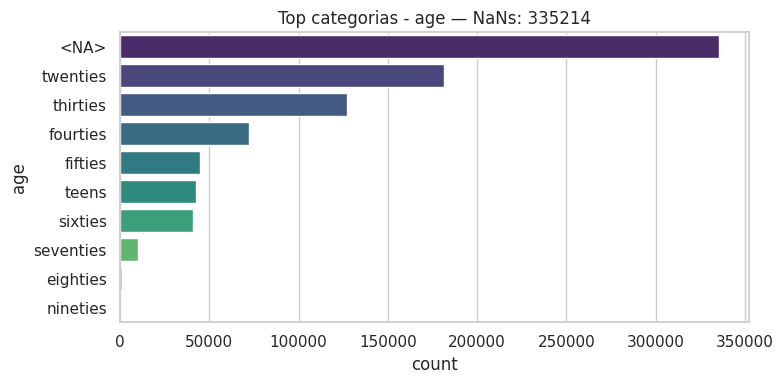

/tmp/ipykernel_98985/1971147714.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette="viridis")


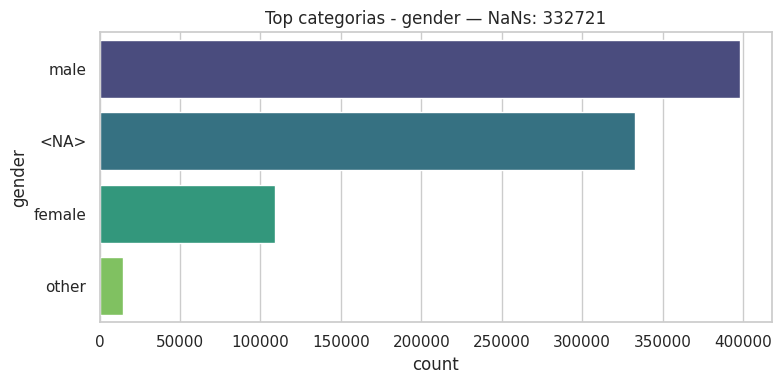

/tmp/ipykernel_98985/1971147714.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette="viridis")


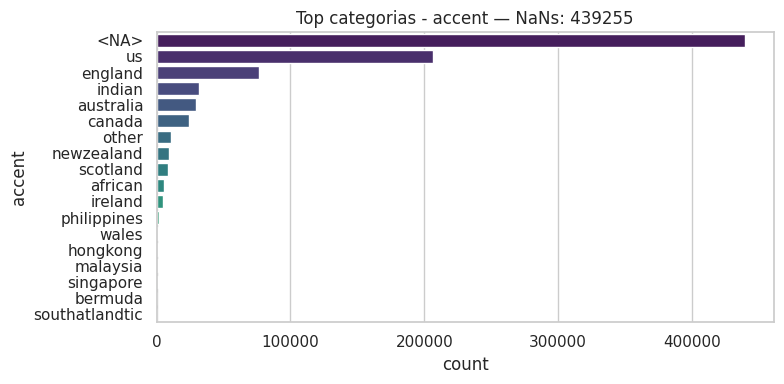

In [6]:
sns.set(style="whitegrid")

skip_cols = {"client_id", "path", "up_votes", "down_votes"}

for col in df.columns:
    if col.lower() in skip_cols:
        continue

    col_series = df[col]
    non_na = col_series.dropna()
    na_count = col_series.isna().sum()
    plt.figure(figsize=(8, 4))

    if pd.api.types.is_numeric_dtype(col_series):
        # Histograma para numéricos
        sns.histplot(non_na, bins=50, kde=False, color="steelblue")
        plt.xlabel(col)
        plt.ylabel("count")
        plt.title(f"Histograma - {col} (numérico) — NaNs: {na_count}")
    else:
        nunique = non_na.nunique()
        if nunique == 0:
            plt.text(0.5, 0.5, "Sem dados não-nulos", ha="center", va="center")
            plt.title(f"{col} — NaNs: {na_count}")
            plt.axis("off")
        elif nunique > 50:
            # Muitas categorias: plotar distribuição de comprimento de texto
            lengths = non_na.astype(str).str.len()
            sns.histplot(lengths, bins=50, color="salmon")
            plt.xlabel("comprimento (caracteres)")
            plt.ylabel("count")
            plt.title(f"Distribuição de comprimento - {col} — NaNs: {na_count}")
        else:
            # Poucas categorias: plotar barras dos top valores
            vc = col_series.fillna("<NA>").value_counts().head(20)
            sns.barplot(x=vc.values, y=vc.index, palette="viridis")
            plt.xlabel("count")
            plt.ylabel(col)
            plt.title(f"Top categorias - {col} — NaNs: {na_count}")

    plt.tight_layout()
    plt.show()

In [7]:
# Filtrar validados
complete_mask = df.notna().all(axis=1)

validated_clips = df[
    complete_mask &
    (df['up_votes'] > df['down_votes']) & 
    (df['up_votes'] >= min_votes)
]

complete_count = int(complete_mask.sum())
complete_pct = complete_count / len(df) * 100

print(f"Áudios com todos os campos presentes: {complete_count} de {len(df)} ({complete_pct:.2f}%)")
print(f"Clips validados: {len(validated_clips)}")
print(f"Taxa de validação: {len(validated_clips)/len(df)*100:.1f}%")

Áudios com todos os campos presentes: 407655 de 854444 (47.71%)
Clips validados: 407655
Taxa de validação: 47.7%


In [11]:
if not dry_run:
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Copiar arquivos validados
    print(f"\nCopiando arquivos para {output_dir}...")
    
    copied = 0
    not_found = 0
    
    for _, row in tqdm(validated_clips.iterrows(), total=len(validated_clips)):
        filename = row['path']
        source = clips_dir / filename
        destination = output_dir / filename

        if source.exists():
            shutil.copy2(source, destination)
            copied += 1
        else:
            not_found += 1
    
    print(f"\nCopiados: {copied} arquivos")
    if not_found > 0:
        print(f"Não encontrados: {not_found} arquivos")

# Salvar metadata filtrado
metadata_output = output_dir / 'validated_metadata.tsv'
validated_clips.to_csv(metadata_output, sep='\t', index=False)
print(f"\nMetadata salvo em: {metadata_output}")


Copiando arquivos para data/1_validated-audio...


100%|██████████| 407655/407655 [00:26<00:00, 15449.71it/s]



Copiados: 407655 arquivos

Metadata salvo em: data/1_validated-audio/validated_metadata.tsv


In [12]:
calculate_total_duration(clips_dir)
print()
calculate_total_duration(output_dir)

Duração total: 889.36 horas (889 horas e 21 minutos)
Duração em segundos: 3201695.69s
Total de arquivos processados: 692666
Arquivos com erro: 49

Duração total: 507.57 horas (507 horas e 33 minutos)
Duração em segundos: 1827237.77s
Total de arquivos processados: 407638
Arquivos com erro: 17


# Audio to spectrogram convertion (STFT)

In [ ]:
input_dir = Path("input_audio")
output_dir = Path("output_audio")
file_extension = "mp3"
sample_rate = None # None para manter a taxa de amostragem original
fft_window_size = 2048 # define resolução
hop_length = fft_window_size // 4 # define sobreposição entre janelas consecutivas
n_mels = 80
cmap = 'magma'